In [ ]:
import sys
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
import itertools
import random

from sklearn.utils import shuffle

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model

from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.regularizers import l2
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
path="/content/drive/MyDrive/sign2/"

In [ ]:
# Get the list of all directories and sort them
dir_list = next(os.walk(path))[1]
dir_list.sort()

In [ ]:
orig_groups, forg_groups = [], []
for directory in dir_list:
    images = os.listdir(path+directory)
    images.sort()
    images = [path+directory+'/'+x for x in images]
    forg_groups.append(images[7:])
    orig_groups.append(images[:7])

In [ ]:
len(orig_groups), len(forg_groups)

(40, 40)

In [ ]:
orig_lengths = [len(x) for x in orig_groups]
forg_lengths = [len(x) for x in forg_groups]

In [ ]:
print(orig_lengths)

[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]


In [ ]:
print(forg_lengths)

[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]


In [ ]:
img_h, img_w = 155, 220

In [ ]:
def visualize_sample_signature():
    '''Function to randomly select a signature from train set and
    print two genuine copies and one forged copy'''
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 10))
    k = np.random.randint(len(orig_train))
    orig_img_names = random.sample(orig_train[k], 2)
    forg_img_name = random.sample(forg_train[k], 1)
    orig_img1 = cv2.imread(orig_img_names[0], 0)
    orig_img2 = cv2.imread(orig_img_names[1], 0)
    forg_img = plt.imread(forg_img_name[0], 0)
    orig_img1 = cv2.resize(orig_img1, (img_w, img_h))
    orig_img2 = cv2.resize(orig_img2, (img_w, img_h))
    forg_img = cv2.resize(forg_img, (img_w, img_h))

    ax1.imshow(orig_img1, cmap = 'gray')
    ax2.imshow(orig_img2, cmap = 'gray')
    ax3.imshow(forg_img, cmap = 'gray')

    ax1.set_title('Genuine Copy')
    ax1.axis('off')
    ax2.set_title('Genuine Copy')
    ax2.axis('off')
    ax3.set_title('Forged Copy')
    ax3.axis('off')

In [ ]:
orig_train, orig_val, orig_test = orig_groups[:20], orig_groups[20:30], orig_groups[30:]
forg_train, forg_val, forg_test = forg_groups[:20], forg_groups[20:30], forg_groups[30:]

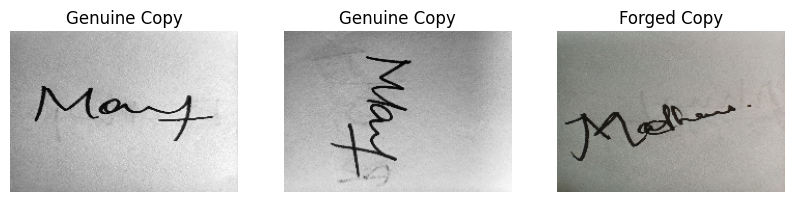

In [ ]:
visualize_sample_signature()

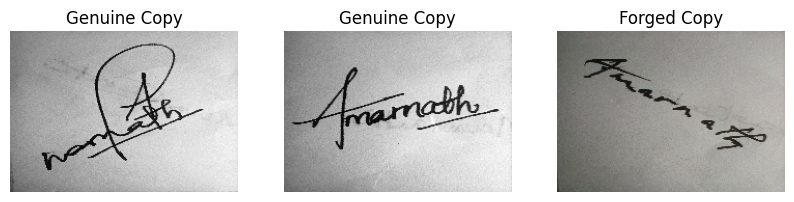

In [ ]:
visualize_sample_signature()

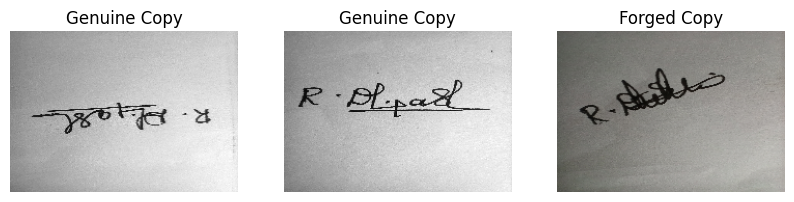

In [ ]:
visualize_sample_signature()

In [ ]:
# Delete unnecessary variables
del orig_groups, forg_groups

In [ ]:
def generate_batch(orig_groups, forg_groups, batch_size = 32):
    '''Function to generate a batch of data with batch_size number of data points
    Half of the data points will be Genuine-Genuine pairs and half will be Genuine-Forged pairs'''
    while True:
        orig_pairs = []
        forg_pairs = []
        gen_gen_labels = []
        gen_for_labels = []
        all_pairs = []
        all_labels = []
        for orig, forg in zip(orig_groups, forg_groups):
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            if len(forg) >= 5:
                forg_pairs.extend(list(itertools.product(orig, forg)))
            else:
                forg_pairs.extend(list(itertools.product(orig, forg*5)))
        gen_gen_labels = [1]*len(orig_pairs)
        gen_for_labels = [0]*len(forg_pairs)

        all_pairs = orig_pairs + forg_pairs
        all_labels = gen_gen_labels + gen_for_labels
        del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)

        k = 0
        pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
        targets=np.zeros((batch_size,))
        for ix, pair in enumerate(all_pairs):
            img1 = cv2.imread(pair[0], 0)
            img2 = cv2.imread(pair[1], 0)
            img1 = cv2.resize(img1, (img_w, img_h))
            img2 = cv2.resize(img2, (img_w, img_h))
            img1 = np.array(img1, dtype = np.float64)
            img2 = np.array(img2, dtype = np.float64)
            img1 /= 255
            img2 /= 255
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield pairs, targets
                k = 0
                pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
                targets=np.zeros((batch_size,))

In [ ]:
def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [ ]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [ ]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [ ]:
input_shape=(img_h, img_w, 1)

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import backend as K

def create_siamese_network(input_shape):
    """Creates a Siamese CNN using Sequential()"""
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu'))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid'))
    
    return model


In [ ]:

base_network = create_siamese_network(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model(inputs=[input_a, input_b], outputs=distance)

In [ ]:
batch_sz = 128
num_train_samples = 14*20 + 49*20
num_val_samples = num_test_samples = 14*10 + 49*10
num_train_samples, num_val_samples, num_test_samples

(1260, 630, 630)

In [ ]:
from tensorflow.keras.optimizers import RMSprop

In [ ]:
rms = RMSprop(learning_rate=1e-4, rho=0.9, epsilon=1e-08)
model.compile(loss=contrastive_loss, optimizer=rms)

In [ ]:
callbacks = [
    EarlyStopping(patience=12, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('/content/drive/MyDrive/sign2/my_model-{epoch:03d}.h5', verbose=1, save_weights_only=True)
]

In [ ]:
results = model.fit(generate_batch(orig_train, forg_train, batch_sz),
                              steps_per_epoch = num_train_samples/batch_sz,
                              epochs = 10,
                              validation_data = generate_batch(orig_val, forg_val, batch_sz),
                              validation_steps = num_val_samples/batch_sz,
                              callbacks = callbacks)

Epoch 1/10
10/9 [==============================] - ETA: 0s - loss: 0.2890
Epoch 1: saving model to /content/drive/MyDrive/sign2/my_model-001.h5
9/9 [==============================] - 107s 12s/step - loss: 0.2890 - val_loss: 0.2600 - lr: 1.0000e-04
Epoch 2/10
10/9 [==============================] - ETA: 0s - loss: 0.1818
Epoch 2: saving model to /content/drive/MyDrive/sign2/my_model-002.h5
9/9 [==============================] - 104s 12s/step - loss: 0.1818 - val_loss: 0.2208 - lr: 1.0000e-04
Epoch 3/10
10/9 [==============================] - ETA: 0s - loss: 0.1561
Epoch 3: saving model to /content/drive/MyDrive/sign2/my_model-003.h5
9/9 [==============================] - 115s 13s/step - loss: 0.1561 - val_loss: 0.2084 - lr: 1.0000e-04
Epoch 4/10
10/9 [==============================] - ETA: 0s - loss: 0.1473
Epoch 4: saving model to /content/drive/MyDrive/sign2/my_model-004.h5
9/9 [==============================] - 106s 12s/step - loss: 0.1473 - val_loss: 0.2290 - lr: 1.0000e-04
Epoch 5/

In [ ]:
def compute_accuracy_roc(predictions, labels):
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1)
    ndiff = np.sum(labels == 0)
   
    step = 0.01
    max_acc = 0
    best_thresh = -1
   
    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d
        idx2 = predictions.ravel() > d
       
        tpr = float(np.sum(labels[idx1] == 1)) / nsame       
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        acc = 0.5 * (tpr + tnr)       
       
        if (acc > max_acc):
            max_acc, best_thresh = acc, d
           
    return max_acc, best_thresh

In [ ]:
model.load_weights('/content/drive/MyDrive/sign2/my_model-010.h5')

In [ ]:
test_gen = generate_batch(orig_test, forg_test, 1)
pred, tr_y = [], []
for i in range(num_test_samples):
    (img1, img2), label = next(test_gen)
    tr_y.append(label)
    pred.append(model.predict([img1, img2])[0][0])

1/1 [==============================] - 0s 21ms/step


In [ ]:
tr_acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y))
tr_acc, threshold

(0.6122448979591837, 0.646883098483086)

In [ ]:
def predict_score():
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_point, test_label = next(test_gen)
    img1, img2 = test_point[0], test_point[1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")

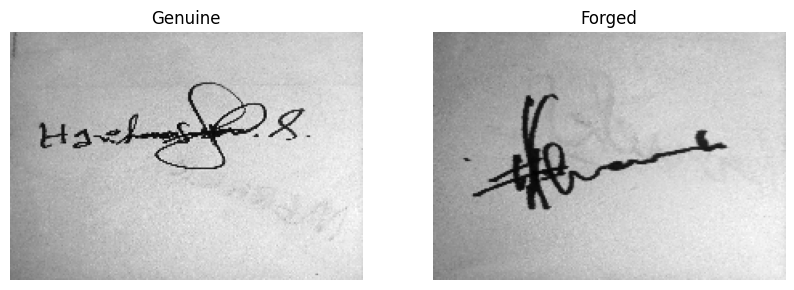

1/1 [==============================] - 0s 30ms/step
Difference Score =  1.406205
Its a Forged Signature


In [ ]:
predict_score()

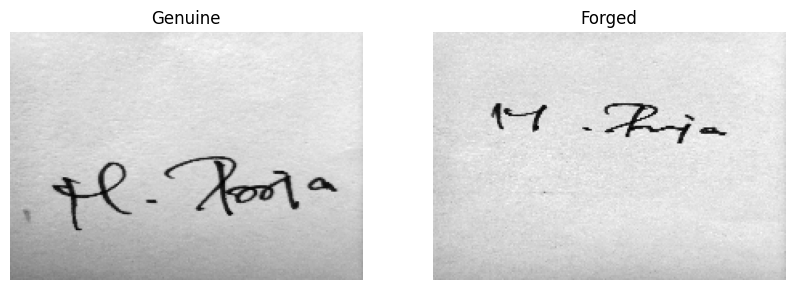

1/1 [==============================] - 0s 19ms/step
Difference Score =  0.658817
Its a Forged Signature


In [ ]:
predict_score()

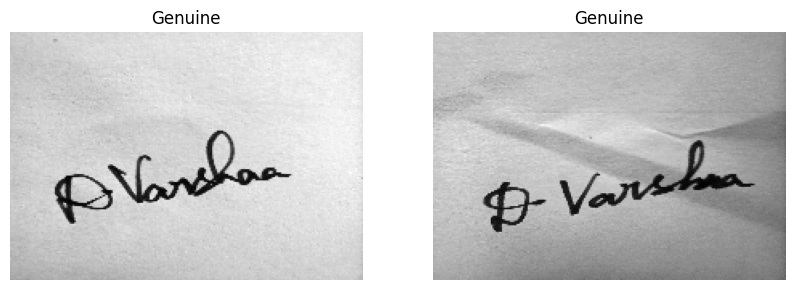

1/1 [==============================] - 0s 29ms/step
Difference Score =  0.58418137
Its a Genuine Signature


In [ ]:
predict_score()

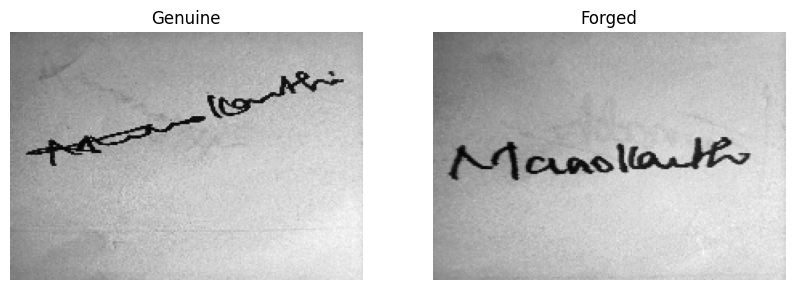

1/1 [==============================] - 0s 29ms/step
Difference Score =  0.69426775
Its a Forged Signature


In [ ]:
predict_score()

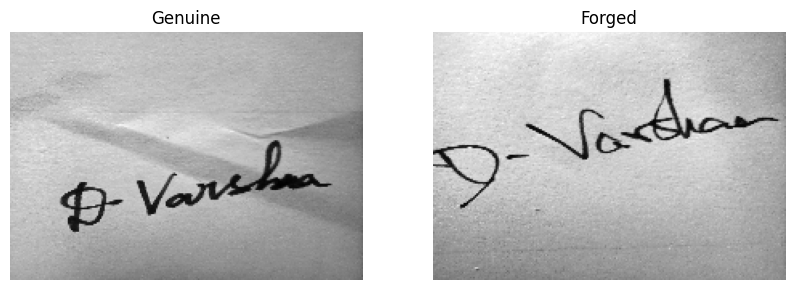

1/1 [==============================] - 0s 42ms/step
Difference Score =  0.959368
Its a Forged Signature


In [ ]:
predict_score()

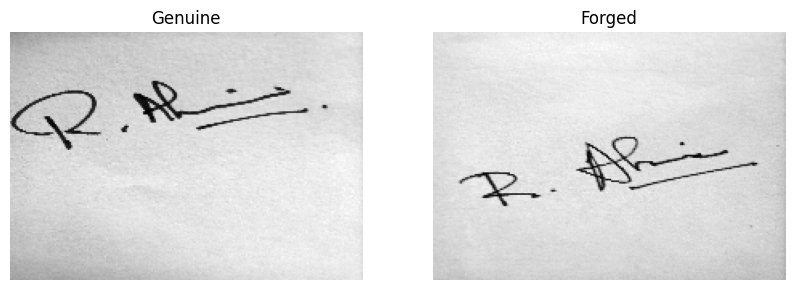

1/1 [==============================] - 0s 27ms/step
Difference Score =  0.8503193
Its a Forged Signature


In [ ]:
predict_score()

In [ ]:
train_gen = generate_batch(orig_test, forg_test, 1)
pred1, tr_y1 = [], []
for i in range(num_train_samples):
    (img1, img2), label = next(train_gen)
    tr_y.append(label)
    pred.append(model.predict([img1, img2])[0][0])

1/1 [==============================] - 0s 24ms/step


In [ ]:
tr_acc = compute_accuracy_roc(np.array(pred1), np.array(tr_y1))
tr_acc 

0.64102381984836
